# Project Overview

Project goal is to generate a cleaned and merged data file in csv format, given 3 ficticious datasets, and provide notes as to what was found in the data, including any missing data.

## Provided Files:
1. Assessment file (sample_assessment.csv): Manhattan School District standardized test results - please include Math score.
2. Math product Usage file (sample_usage.csv): Please include both lessons completed and total minutes columns in the merged file. Students in grade levels 5, 6, 7, and 8 have access to the Math product.
3. SIS file (sample_sis.csv): Please include all information listed in this file (all students in grade levels 5, 6, 7, and 8) and all columns.



# Setup

In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# Allows plots to be rendered inside the notebook
%matplotlib inline

In [2]:
# Load files
sis_data = pd.read_csv('./resources/sample_sis.csv')
assessment_data = pd.read_csv('./resources/sample_assessment.csv')
usage_data = pd.read_csv('./resources/sample_usage.csv')

In [3]:
# Create list of dataframes for ease of programming
dataframes = [("SIS Data", sis_data), ("Assessment Data", assessment_data), ("Usage Data", usage_data)]

# Data Overview

In [40]:
# View headers
sis_data.head()

,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch
0,1254353,7,White,Male,No
1,1254135,5,White,Male,NaN
2,1254423,8,Black/African American,Male,Reduced Price
3,1254598,8,White,Male,Free
4,1254562,6,Black/African American,Male,No


In [41]:
assessment_data.head()

,student_id,student_number,subject,score
0,1254397,54912357,ELA,190
1,1254204,54912164,ELA,567
2,1254785,54912745,ELA,390
3,1254308,54912268,Math,719
4,1254560,54912520,ELA,394


In [42]:
usage_data.head()

,student_id,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes
0,1254110,13,level 2,level 1,level 3,level 2,47.808670
1,1254113,14,level 2,level 1,level4,level 1,156.792335
2,1254288,16,level 3,level 1,level 3,level 1,38.135959
3,1254095,15,level 3,level 1,level 1,level 1,18.257427
4,1254250,1,level 2,level 1,level 2,level 2,16.479016


## Cursory Observations
- Relationship column between files is Student ID (student_id).
    - While the Usage & SIS files have a clearly labeled student_id column, the Assessment file has two possible columns that could be Student ID, either id or student_number. 
    - All id-related columns have 7 digits, but the id column in the Assessments file has similar leading numbers as the student_id columns in the other two files.
- Additional header observations:
    - File headers have incongruent formats- spacing vs underscores, mixed casing, includes slash character. 
    - The directions require “lessons completed”, whereas the column header is “lesson completed”.
- NaN value is present in Free/Reduced Price Lunch.
- Benchmark value format is inconsistent.
- Since Math scores are the focus, I'll need to check & filter the subject column.
- Since Grade Level determines access to the Usage file, I'll need to check and filter the grade_level column.

# Normalize Headers

In [4]:
custom_mappings = {
    'lesson_completed': 'lessons_completed',
    'id': 'student_id'
}

for name, df in dataframes:
    df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_').str.replace(r'[^\w]', '')
    if custom_mappings:
        df.rename(columns=custom_mappings, inplace=True)


# Analyze Data in Preparation for Merge

In [28]:
for name, df in dataframes:
    print(name, "Info:")
    df.info()
    print("\n")

SIS Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   student_id                783 non-null    int64 
 1   grade_level               783 non-null    int64 
 2   race_ethnicity            736 non-null    object
 3   gender                    783 non-null    object
 4   free_reduced_price_lunch  669 non-null    object
dtypes: int64(2), object(3)
memory usage: 30.7+ KB


Assessment Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   student_id      1280 non-null   int64 
 1   student_number  1280 non-null   int64 
 2   subject         1280 non-null   object
 3   score           1280 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 40.1+ KB


Usage

<div class="alert alert-block alert-success">
<b>Data Type Consistency</b> Column Data Types are as expected. Student ID's and other int-expected columns are integers. Columns with expected string values are objects. Total minutes are floats.
</div>

<div class="alert alert-block alert-danger">
<b>Null or NaN:</b> I can see there are Null or NaN values in the SIS Data for columns race/ethnicity and free/reduced price lunch, but these are non-essential columns.
</div>

## Check ID Columns

In [38]:
# SIS IDs
sis_data.describe()['student_id']

count    7.830000e+02
mean     1.254464e+06
std      2.261769e+02
min      1.254073e+06
25%      1.254268e+06
50%      1.254464e+06
75%      1.254660e+06
max      1.254855e+06
Name: student_id, dtype: float64

In [42]:
# Assessment IDs
assessment_data.describe()['student_id']

count    1.280000e+03
mean     1.254502e+06
std      1.848241e+02
min      1.254183e+06
25%      1.254343e+06
50%      1.254502e+06
75%      1.254662e+06
max      1.254822e+06
Name: student_id, dtype: float64

In [43]:
# Usage IDs
usage_data.describe()['student_id']

count    3.490000e+02
mean     1.254239e+06
std      1.008919e+02
min      1.254065e+06
25%      1.254152e+06
50%      1.254239e+06
75%      1.254326e+06
max      1.254413e+06
Name: student_id, dtype: float64

<div class="alert alert-block alert-success">
<b>No Messy Data in ID Columns</b> There are no outliers, negatives, zeros, or placeholder data in the Student ID columns in any data set.
    <dl>
        <dt>SIS Data: IQR=392, Threshold=588</dt>
            <dd>- Min value above lower bound of 1,253,680</dd>
            <dd>- Max value above lower bound of 1,255,248</dd>
        <dt>Assessment Data: IQR=319, Threshhold=478.5</dt>
            <dd>- Min value above lower bound of 1,253,704.5</dd>
            <dd>- Max value above lower bound of 1,255,140.5</dd>
        <dt>Usage Data: IQR=174, Threshold=261</dt>
            <dd>- Min value above lower bound of 1,253,891</dd>
            <dd>- Max value above lower bound of 1,254,587</dd>
    </dl>
</div>

### Check ID Columns for Duplicates

In [59]:
for name, df in dataframes:
    print(f"{name} has duplicates?: {df['student_id'].duplicated().any()}")

SIS Data has duplicates?: False
Assessment Data has duplicates?: True
Usage Data has duplicates?: False


<div class="alert alert-block alert-warning">
<b>Duplicates as Expected:</b> Assessment Data has student scores for both Math & ELA. SIS & Usage have no duplicates. Assessment Data will need to be handled accordingly.
</div>

## Check Other Columns

In [68]:
# Check specific columns for values less than 0
for name, df in dataframes:
    print(f"Checking {name}...")
    found = False
    for column in df.select_dtypes(include=['number']).columns:
        if column in df.columns and pd.api.types.is_numeric_dtype(df[column]):
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            if (df[column] < lower_bound).any() | (df[column] > upper_bound).any():
                found = True
                print(f"  Column '{column}' in {name} has outliers.")
            if (df[column] < 1).any():
                found = True
                print(f"  Column '{column}' in {name} has less than 1.")
            if (df[column] == 0).any():
                found = True
                print(f"  Column '{column}' in {name} has zeroes.")
            if (df[column] < 0).any():
                found = True
                print(f"  Column '{column}' in {name} has negatives.")

    if (not found):
        print("No inconsistencies found.")

Checking SIS Data...
No inconsistencies found.
Checking Assessment Data...
No inconsistencies found.
Checking Usage Data...
  Column 'total_minutes' in Usage Data has outliers.
  Column 'total_minutes' in Usage Data has less than 1.


In [67]:
# Usage IDs
usage_data.describe()['total_minutes']

count    349.000000
mean      76.705856
std       56.142303
min        0.167026
25%       32.308333
50%       65.030197
75%      111.739739
max      280.517175
Name: total_minutes, dtype: float64

In [69]:
def get_outliers_and_issues(df):
    result_rows = pd.DataFrame()
    
    for column in df.select_dtypes(include=['number']).columns:
        col_data = df[column]
        
        # Calculate IQR for outlier detection
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify rows with issues
        issues = df[(col_data < lower_bound) | 
                    (col_data > upper_bound) | 
                    (col_data == 0) | 
                    (col_data < 0) |
                    (col_data < 1)]
        
        # Add a column to indicate which issue was detected
        issues = issues.copy()  # Avoid SettingWithCopyWarning
        issues['issue_column'] = column  # Column with the detected issue
        
        result_rows = pd.concat([result_rows, issues])
    
    # Remove duplicates in case multiple columns flagged the same row
    return result_rows.drop_duplicates()

# Example Usage
outlier_rows = get_outliers_and_issues(usage_data)
print(outlier_rows)


     student_id  lessons_completed benchmark_1_level benchmark_2_level  \
16      1254138                 12            level4           level 3   
24      1254393                 16           level 2           level 2   
69      1254280                  4           level 1           level 2   
154     1254252                  9           level 3           level 3   
171     1254367                 13            level4           level 3   
179     1254255                 14           level 2           level 3   
261     1254284                 23           level 3           level 2   

    benchmark_3_level benchmark_4_level  total_minutes   issue_column  
16            level 1           level 3     255.231657  total_minutes  
24            level 1           level 1       0.167026  total_minutes  
69            level 1           level 1     261.391669  total_minutes  
154           level 2            level4     247.638391  total_minutes  
171           level 2           level 2     280

<div class="alert alert-block alert-danger">
<b>Total Minutes < 1</b> Data shows 3 students were able to complete between 14-23 lessons in less than 1 minute.
</div>

In [55]:
# Check SIS Grade Levels are as expected (5-8)
print(sis_data['grade_level'].unique())

[7 5 8 6]


In [10]:
# Check SIS Race/Ethnicity values
print(sis_data['race_ethnicity'].unique())

['White' 'Black/African American' 'Two or More Races' nan 'Asian'
 'Native Havaiian/Other Pacific Islander' 'American Indian/Alaska Native'
 'Hispanic/Latino']


In [11]:
# Check SIS Free/Reduced Price Lunch values
print(sis_data['free_reduced_price_lunch'].unique())

['No' nan 'Reduced Price' 'Free']


In [56]:
# Check Assessment Subjects are as expected (Math or ELA)
print(assessment_data['subject'].unique())

['ELA' 'Math']


## Handle SIS Data

In [39]:
# Check all SIS columns for NaN or blank values
null_counts = sis_data.isnull().sum()
blank_counts = sis_data.apply(lambda col: col.astype(str).str.strip().eq('').sum())

# Combine into a summary DataFrame
issue_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Blank Count': blank_counts
})
print(issue_summary)


                          Null Count  Blank Count
student_id                         0            0
grade_level                        0            0
race_ethnicity                    47            0
gender                             0            0
free_reduced_price_lunch         114            0


In [27]:
# Get the IDs where NaN in SIS Race/Ethnicity column
ids_with_race_nan = sis_data[sis_data['race_ethnicity'].isna()]['student_id'].tolist()
print(ids_with_race_nan)

# Filter rows with NaN in Race/Ethnicity column
race_ethnicity_nans = sis_data[sis_data['race_ethnicity'].isna()]
race_ethnicity_nans.head(5)

[1254825, 1254771, 1254180, 1254104, 1254079, 1254332, 1254503, 1254475, 1254810, 1254574, 1254378, 1254328, 1254327, 1254815, 1254364, 1254350, 1254745, 1254755, 1254756, 1254299, 1254545, 1254643, 1254488, 1254089, 1254778, 1254537, 1254291, 1254555, 1254616, 1254305, 1254214, 1254245, 1254387, 1254762, 1254663, 1254461, 1254689, 1254377, 1254449, 1254735, 1254518, 1254094, 1254249, 1254549, 1254493, 1254192, 1254708]


,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch
33,1254825,7,NaN,Male,NaN
35,1254771,5,NaN,Male,No
48,1254180,8,NaN,Male,NaN
61,1254104,8,NaN,Male,No
65,1254079,5,NaN,Female,No


In [26]:
# Get the IDs where NaN in SIS Free/Reduced Lunch column
ids_with_lunch_nan = sis_data[sis_data['free_reduced_price_lunch'].isna()]['student_id'].tolist()
print(ids_with_lunch_nan)

# Filter rows with NaN in SIS Free/Reduced Lunch column
free_reduced_price_lunch_nans = sis_data[sis_data['free_reduced_price_lunch'].isna()]
free_reduced_price_lunch_nans.head(5)

[1254135, 1254128, 1254588, 1254529, 1254825, 1254767, 1254180, 1254112, 1254308, 1254819, 1254292, 1254516, 1254799, 1254577, 1254489, 1254508, 1254258, 1254212, 1254166, 1254839, 1254614, 1254743, 1254436, 1254260, 1254617, 1254666, 1254441, 1254400, 1254583, 1254818, 1254628, 1254697, 1254726, 1254760, 1254201, 1254700, 1254167, 1254533, 1254654, 1254746, 1254363, 1254442, 1254824, 1254123, 1254541, 1254576, 1254478, 1254840, 1254426, 1254627, 1254664, 1254597, 1254343, 1254846, 1254324, 1254147, 1254145, 1254256, 1254836, 1254089, 1254276, 1254837, 1254551, 1254572, 1254605, 1254222, 1254103, 1254404, 1254233, 1254136, 1254672, 1254205, 1254099, 1254295, 1254710, 1254163, 1254655, 1254293, 1254220, 1254121, 1254111, 1254307, 1254543, 1254582, 1254278, 1254625, 1254741, 1254229, 1254369, 1254482, 1254134, 1254550, 1254368, 1254348, 1254590, 1254440, 1254641, 1254548, 1254281, 1254325, 1254411, 1254479, 1254785, 1254669, 1254091, 1254843, 1254702, 1254119, 1254829, 1254523, 1254624, 

,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch
1,1254135,5,White,Male,NaN
17,1254128,8,White,Male,NaN
19,1254588,7,Two or More Races,Male,NaN
25,1254529,7,Black/African American,Female,NaN
33,1254825,7,NaN,Male,NaN


## Handle Assessment Data

In [12]:
# Split Assessment Data into Math vs ELA
assessment_ela = assessment_data[assessment_data['subject'] == 'ELA']
assessment_math = assessment_data[assessment_data['subject'] == 'Math']

assessment_math.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640 entries, 3 to 1279
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   student_id      640 non-null    int64 
 1   student_number  640 non-null    int64 
 2   subject         640 non-null    object
 3   score           640 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 25.0+ KB


In [13]:
# Create list of new dataframes for ease of programming
math_dataframes = [("SIS Data", sis_data), ("Assessment Math Data", assessment_math), ("Usage Data", usage_data)]


In [14]:
for name, df in math_dataframes:
    print(f"{name} has duplicates?: {df['student_id'].duplicated().any()}")

SIS Data has duplicates?: False
Assessment Math Data has duplicates?: False
Usage Data has duplicates?: False


<div class="alert alert-block alert-success">
<b>No Duplicate IDs Found</b> No duplicates found after removing ELA from Assessments
</div>

In [31]:
# Comparing Differences between data
assessment_math_ids = np.array(assessment_math['student_id'])
assessment_ela_ids = np.array(assessment_ela['student_id'])
usage_ids = np.array(usage_data['student_id'])
sis_ids = np.array(sis_data['student_id'])

print("IDs in Assessment but not in SIS:", len(np.setdiff1d(assessment_math_ids, sis_ids)))
print("IDs in Usage but not in SIS:", len(np.setdiff1d(usage_ids, sis_ids)))

print("IDs in SIS but not in Assessment:", len(np.setdiff1d(sis_ids, assessment_math_ids)))
print("IDs in SIS but not in Usage:", len(np.setdiff1d(sis_ids, usage_ids)))

print("IDs in Assessment but not in Usage:", len(np.setdiff1d(assessment_math_ids, usage_ids)))
print("IDs in Usage but not in Assessment:", len(np.setdiff1d(usage_ids, assessment_math_ids)))


IDs in Assessment but not in SIS: 0
IDs in Usage but not in SIS: 8
IDs in SIS but not in Assessment: 143
IDs in SIS but not in Usage: 442
IDs in Assessment but not in Usage: 409
IDs in Usage but not in Assessment: 118


In [44]:
# List Missing Data (ID's in Usage but not in SIS)
missing_usage_ids = np.setdiff1d(usage_ids, sis_ids)
print("IDs in Usage but not in SIS:", missing_usage_ids)

missing_usage_data = usage_data[usage_data['student_id'].isin(missing_usage_ids)]

missing_usage_data

IDs in Usage but not in SIS: [1254065 1254066 1254067 1254068 1254069 1254070 1254071 1254072]


,student_id,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes
40,1254070,7,level4,level 3,level 1,level4,134.195032
46,1254069,23,level4,level 2,level 3,level 1,59.247430
77,1254065,5,level4,level 3,level 1,level4,124.325568
144,1254072,24,level 1,level 3,level 1,level 3,129.205541
200,1254068,18,level 3,level 3,level4,level 1,5.879212
221,1254066,16,level 1,level 1,level4,level 3,12.492581
263,1254067,4,level 2,level4,level 2,level 2,63.419238
309,1254071,14,level 2,level 3,level4,level 2,228.975415


<div class="alert alert-block alert-danger">
<b>Missing Data:</b> These rows are in the Usage file, but not in the SIS file.
</div>

In [45]:
# Check for assessment data in missing Usage ID's
print("Common IDs between missing usage data & assessment data:", len(np.intersect1d(missing_usage_ids, assessment_math_ids)))

Common IDs between missing usage data & assessment data: 0


In [33]:
# Check for unique ELA ID's 
print("IDs in Assessment ELA but not in Assessment Math:", len(np.setdiff1d(assessment_ela_ids, assessment_math_ids)))

IDs in Assessment ELA but not in Assessment Math: 0


## Handle Usage Data

In [32]:
# Put Benchmark columns into a list
benchmark_columns = ['benchmark_1_level', 'benchmark_2_level', 'benchmark_3_level', 'benchmark_4_level']

# Check Usage Benchmarks
for col in benchmark_columns:
    print(f"Unique values in {col}: {usage_data[col].unique()}")

Unique values in benchmark_1_level: ['level 2' 'level 3' 'level 1' 'level4']
Unique values in benchmark_2_level: ['level 1' 'level 2' 'level 3' 'level4']
Unique values in benchmark_3_level: ['level 3' 'level4' 'level 1' 'level 2']
Unique values in benchmark_4_level: ['level 2' 'level 1' 'level4' 'level 3']


<div class="alert alert-block alert-danger">
<b>Messy Data in Benchmark Columns:</b> All level values have a space between text and number except for "level4" in each column.
</div>

In [33]:
# Replace "level4" with "level 4" in the specified columns
for column in benchmark_columns:
    usage_data[column] = usage_data[column].replace('level4', 'level 4')

usage_data.head(5)

,student_id,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes
0,1254110,13,level 2,level 1,level 3,level 2,47.808670
1,1254113,14,level 2,level 1,level 4,level 1,156.792335
2,1254288,16,level 3,level 1,level 3,level 1,38.135959
3,1254095,15,level 3,level 1,level 1,level 1,18.257427
4,1254250,1,level 2,level 1,level 2,level 2,16.479016


In [17]:
# Benchmark level distribution
melted = usage_data.melt(id_vars=['student_id'], 
                       value_vars=['benchmark_1_level', 'benchmark_2_level', 'benchmark_3_level', 'benchmark_4_level'], 
                       var_name='benchmark', 
                       value_name='level')
melted.head(10)

,student_id,benchmark,level
0,1254110,benchmark_1_level,level 2
1,1254113,benchmark_1_level,level 2
2,1254288,benchmark_1_level,level 3
3,1254095,benchmark_1_level,level 3
4,1254250,benchmark_1_level,level 2
5,1254177,benchmark_1_level,level 1
6,1254277,benchmark_1_level,level 3
7,1254078,benchmark_1_level,level 2
8,1254165,benchmark_1_level,level 2
9,1254381,benchmark_1_level,level 3


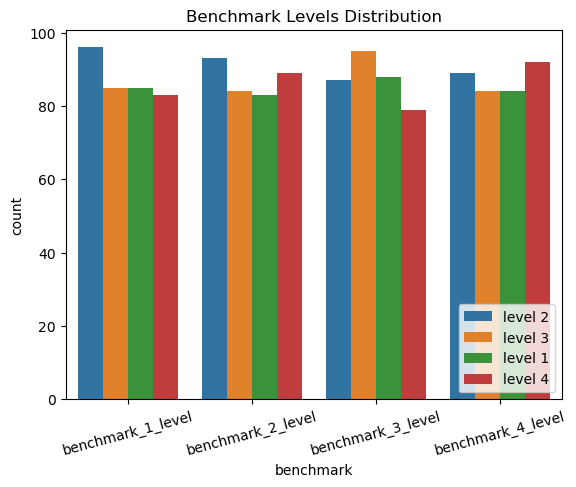

In [18]:
sb.countplot(data=melted, x='benchmark', hue='level')
plt.title("Benchmark Levels Distribution")
plt.xticks(rotation=15)
plt.legend(loc = 4) 
plt.show()

In [48]:
for col in ['benchmark_1_level', 'benchmark_2_level', 'benchmark_3_level', 'benchmark_4_level']:
    print(usage_data[col].value_counts())


benchmark_1_level
level 2    96
level 3    85
level 1    85
level4     83
Name: count, dtype: int64
benchmark_2_level
level 2    93
level4     89
level 3    84
level 1    83
Name: count, dtype: int64
benchmark_3_level
level 3    95
level 1    88
level 2    87
level4     79
Name: count, dtype: int64
benchmark_4_level
level4     92
level 2    89
level 1    84
level 3    84
Name: count, dtype: int64


In [51]:
for col in ['lessons_completed']:
    print(f"Correlation with total_minutes for {col}: {usage_data[col].corr(usage_data['total_minutes'])}")


Correlation with total_minutes for lessons_completed: -0.04444975594260643


# Merge Data
- Use SIS data as base, into which other data is merged

In [43]:
# Merge SIS and Usage
merged_df = sis_data.merge(usage_data, on='student_id', how='left')

# Merge the result with Assessment
merged_df = merged_df.merge(assessment_math, on='student_id', how='left')

# Display the merged dataset
merged_df.head(10)


,student_id,grade_level,race_ethnicity,gender,free_reduced_price_lunch,lessons_completed,benchmark_1_level,benchmark_2_level,benchmark_3_level,benchmark_4_level,total_minutes,student_number,subject,score
0,1254353,7,White,Male,No,24.0,level 2,level 2,level 2,level 2,21.040558,54912313.0,Math,289.0
1,1254135,5,White,Male,NaN,1.0,level 2,level 2,level 3,level 3,53.124390,NaN,NaN,NaN
2,1254423,8,Black/African American,Male,Reduced Price,NaN,NaN,NaN,NaN,NaN,NaN,54912383.0,Math,614.0
3,1254598,8,White,Male,Free,NaN,NaN,NaN,NaN,NaN,NaN,54912558.0,Math,578.0
4,1254562,6,Black/African American,Male,No,NaN,NaN,NaN,NaN,NaN,NaN,54912522.0,Math,395.0
5,1254213,8,White,Male,No,21.0,level4,level 3,level4,level 1,11.374870,54912173.0,Math,518.0
6,1254122,5,Black/African American,Female,Reduced Price,8.0,level 2,level 3,level4,level4,82.582013,NaN,NaN,NaN
7,1254275,7,White,Male,Reduced Price,16.0,level 2,level 3,level4,level 3,133.622386,54912235.0,Math,601.0
8,1254600,6,Black/African American,Female,No,NaN,NaN,NaN,NaN,NaN,NaN,54912560.0,Math,705.0
9,1254828,5,White,Female,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   student_id                783 non-null    int64  
 1   grade_level               783 non-null    int64  
 2   race_ethnicity            736 non-null    object 
 3   gender                    783 non-null    object 
 4   free_reduced_price_lunch  669 non-null    object 
 5   lessons_completed         341 non-null    float64
 6   benchmark_1_level         341 non-null    object 
 7   benchmark_2_level         341 non-null    object 
 8   benchmark_3_level         341 non-null    object 
 9   benchmark_4_level         341 non-null    object 
 10  total_minutes             341 non-null    float64
 11  student_number            640 non-null    float64
 12  subject                   640 non-null    object 
 13  score                     640 non-null    float64
dtypes: float64

In [38]:
# Check all columns for NaN or blank values
full_null_counts = merged_df.isnull().sum()
full_blank_counts = merged_df.apply(lambda col: col.astype(str).str.strip().eq('').sum())

# Combine into a summary DataFrame
full_issue_summary = pd.DataFrame({
    'Null Count': full_null_counts,
    'Blank Count': full_blank_counts
})
print(full_issue_summary)

                          Null Count  Blank Count
student_id                         0            0
grade_level                        0            0
race_ethnicity                    47            0
gender                             0            0
free_reduced_price_lunch         114            0
lessons_completed                442            0
benchmark_1_level                442            0
benchmark_2_level                442            0
benchmark_3_level                442            0
benchmark_4_level                442            0
total_minutes                    442            0
student_number                   143            0
subject                          143            0
score                            143            0


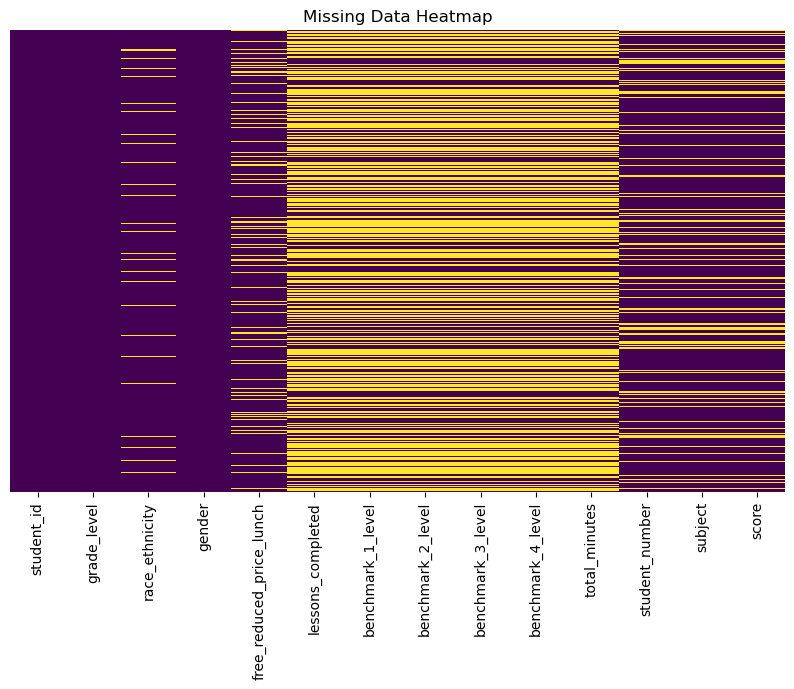

In [47]:
# Check missing data across columns
missing_data = merged_df.isnull()

# Visualize as a heatmap
plt.figure(figsize=(10, 6))
sb.heatmap(missing_data, cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

In [56]:
# Fill NaN in lessons_completed and total_minutes with 0
merged_df['lessons_completed'].fillna(0)
merged_df['total_minutes'].fillna(0)

# Fill NaN in score with -1 to indicate no assessment taken
merged_df['score'].fillna(-1)


0      289.0
1       -1.0
2      614.0
3      578.0
4      395.0
       ...  
778    290.0
779    196.0
780    557.0
781    433.0
782    717.0
Name: score, Length: 783, dtype: float64

# Scratch Pad

In [52]:
# Correlations
for col in ['lessons_completed', 'total_minutes']:
    print(f"Correlation with Score for {col}: {merged_df[col].corr(merged_df['score'])}")


Correlation with Score for lessons_completed: -0.16664187473992423
Correlation with Score for total_minutes: 0.1072420936688609


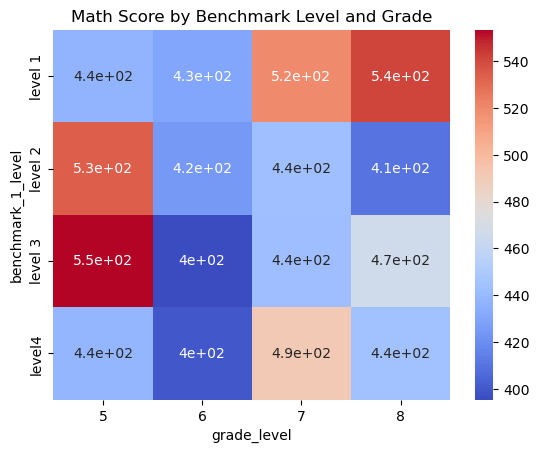

In [54]:
heatmap_data = merged_df.groupby(['benchmark_1_level', 'grade_level'])['score'].mean().unstack()
sb.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title("Math Score by Benchmark Level and Grade")
plt.show()


In [29]:
# Identify Duplicate ID rows

assessment_duplicate_rows = assessment_data[assessment_data.duplicated(subset=['id'], keep=False)]
print(assessment_duplicate_rows)

           id  student_number subject  score
0     1254397        54912357     ELA    190
1     1254204        54912164     ELA    567
2     1254785        54912745     ELA    390
3     1254308        54912268    Math    719
4     1254560        54912520     ELA    394
...       ...             ...     ...    ...
1275  1254205        54912165     ELA    615
1276  1254564        54912524     ELA    382
1277  1254424        54912384    Math    750
1278  1254358        54912318     ELA    304
1279  1254500        54912460    Math    105

[1280 rows x 4 columns]


In [49]:
for name, df in dataframes:
    print(f"Checking {name}...")
    found = False
    for column in df.select_dtypes(include=['int64', 'float64']).columns:
        if (df[column] < 0).any():
            print(f"  Column '{column}' in {name} has values less than 1.")
            found = True

    
    if (not found):
        print("No inconsistencies found.")

Checking SIS Data...
No inconsistencies found.
Checking Assessment Data...
No inconsistencies found.
Checking Usage Data...
No inconsistencies found.


In [24]:
# Confirm ID columns have no negative or zero values
sis_invalid_ids = sis_data['student_id'] <= 0
print("SIS Invalid IDs:", sis_data[sis_invalid_ids])

assessment_invalid_ids = assessment_data['id'] <= 0
print("Assessment Invalid IDs:", assessment_data[assessment_invalid_ids])

assessment_invalid_nums = assessment_data['student_number'] <= 0
print("Assessment Invalid Nums:", assessment_data[assessment_invalid_nums])

usage_invalid_ids = usage_data['student_id'] <= 0
print("Usage Invalid IDs:", usage_data[usage_invalid_ids])

SIS Invalid IDs: Empty DataFrame
Columns: [student_id, grade_level, race_ethnicity, gender, Free/Reduced Price Lunch]
Index: []
Assessment Invalid IDs: Empty DataFrame
Columns: [id, student_number, subject, score]
Index: []
Assessment Invalid Nums: Empty DataFrame
Columns: [id, student_number, subject, score]
Index: []
Usage Invalid IDs: Empty DataFrame
Columns: [student_id, lesson completed, benchmark_1_level, benchmark_2_level, benchmark_3_level, benchmark_4_level, total_minutes]
Index: []


In [12]:
# Total problematic values (NaN + blank)
total_issues = (assessment_data['id'].isnull() | assessment_data['id'].astype(str).str.strip().eq('')).sum()
print("Total number of problematic values:", total_issues)

Total number of problematic values: 0


In [29]:
# intersection

sis_assess_intersection = np.intersect1d(assessment_math_ids, sis_ids)
usage_assess_intersection = np.intersect1d(assessment_math_ids, usage_ids)
# print("Common IDs between assessment and SIS:", len(sis_assess_intersection))
# print("Common IDs between assessment and Usage:", len(usage_assess_intersection))

NameError: name 'assessment_math_ids' is not defined

In [ ]:
# Drop unnecessary columns
# Drop columns 'A' and 'C'
clean_merged = merged_df.drop(['A', 'C'], axis=1)